# Titanic: Machine Learning from Disaster

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings("ignore")

# 1. Data Overview

In [2]:
# loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


There are 10 predictors, of which:
* 'Pclass', 'Title', 'Sex', 'Embarked' are categorical.
* 'Age', 'Fare' are continuous.
* 'SibSp', 'Parch' are discrete.
* 'Ticket', 'Cabin' are alphanumeric.

In [3]:
train.shape

(891, 12)

In [4]:
test.shape

(418, 11)

# 2.Data Cleaning and Analysis

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

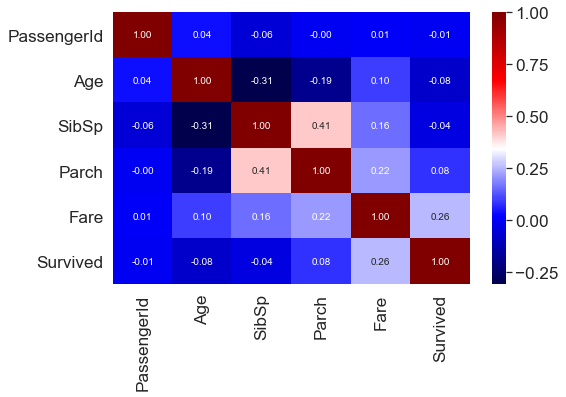

In [6]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.heatmap(train[['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(), annot = True, fmt=".2f", cmap="seismic")

By visualizing the correlation between the correlation between features, higher value means stronger correlation.From the graph we could see that Fare is a important feature for Survived.



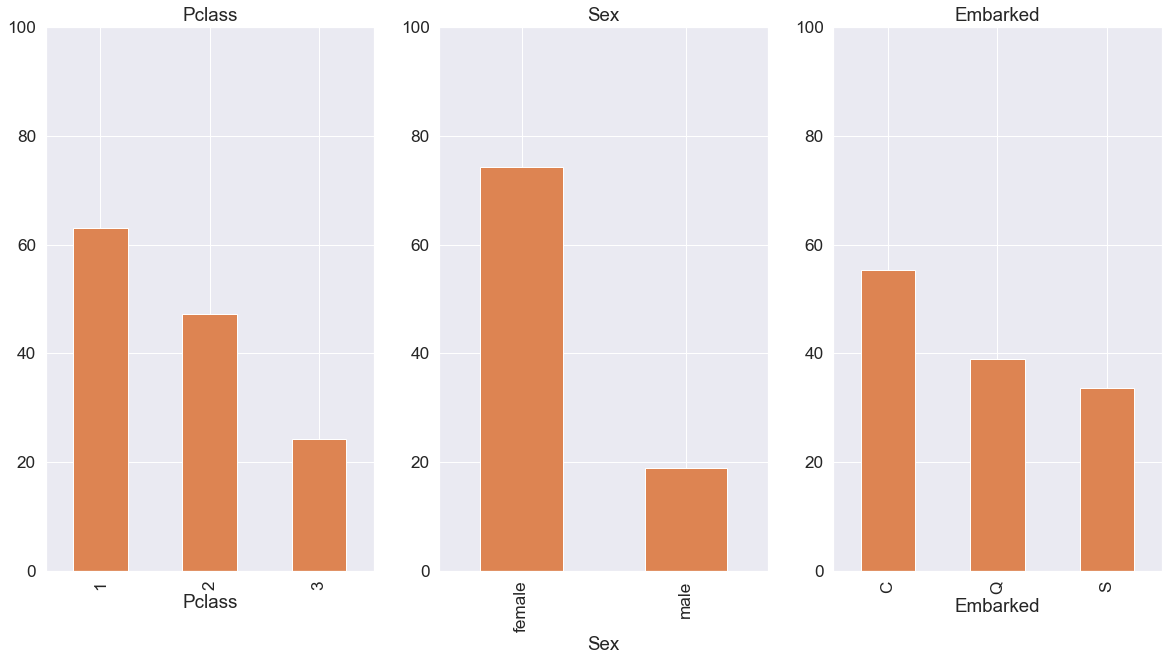

In [7]:
# Plot the categorical predictors against survival rate

var = ['Pclass', 'Sex', 'Embarked']
num_cols = len(var)

fig, axes = plt.subplots(ncols=num_cols)
for i in var:
    train.pivot_table('PassengerId', i, 'Survived', 'count')\
    .apply(lambda x: x.div(x.sum()).mul(100), axis=1)[1]\
    .plot(ax=axes[var.index(i)%num_cols], kind='bar', stacked=True, title=i, figsize=(20, 10), color='C1')\
    .set_ylim([0,100])
    

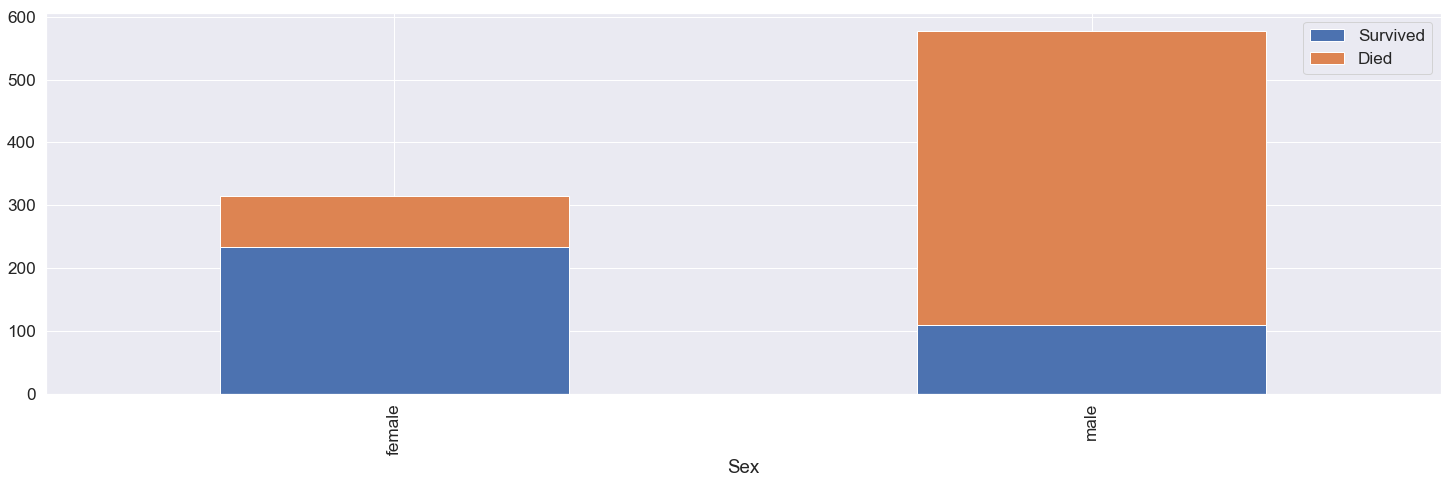

In [8]:
#Relationship between Sex and Survival rate
train['Died'] = 1 - train['Survived']
train.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, );

From the plot above, we can see that the chance of surviving is higher if:
* The person came from a higher class (lower value of Pclass)
* The person was young (Master or Miss) or female (Miss or Mrs)
* The person was female
* The person embarked at C

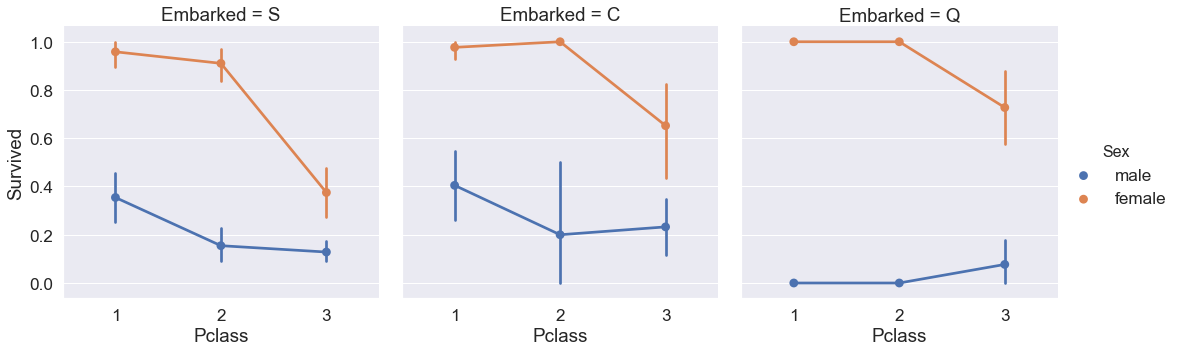

In [9]:
#Relationship between Pclass and Survival rate
sns.catplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train,kind='point')

# 3. Feature Engineering 

In [10]:
all_data = [train, test]
for dataset in all_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,S,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,C,0


**Fare**

In [11]:
#method 1
# Filling missing values
all_data = [train, test]
for dataset in all_data:
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

# Making Bins
    dataset['FareCut'] = pd.qcut(dataset['Fare'], 5)
    label = LabelEncoder()
    dataset['FareCutTran'] = label.fit_transform(dataset['FareCut'])


**FmailyCount**

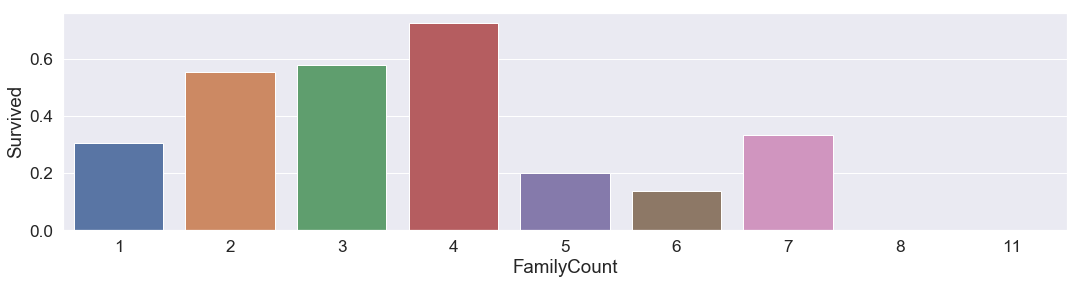

In [12]:
# Family_size
all_data = [train, test]
for dataset in all_data:
    dataset['FamilyCount'] = dataset['SibSp'] + dataset['Parch'] + 1
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
name_length = train[['FamilyCount','Survived']].groupby(['FamilyCount'],as_index=False).mean()
sns.barplot(x='FamilyCount', y='Survived', data=name_length)

In [13]:
train[train['Ticket'].notnull()]['Ticket'].sample(5)

92            W.E.P. 5734
131    SOTON/O.Q. 3101307
734                233639
511      SOTON/OQ 3101316
221                220367
Name: Ticket, dtype: object

In [14]:
data=train.append(test)
# the same ticket family or friends

DEFAULT_SURVIVAL_VALUE = 0.5
data['FamilySurvival'] =   DEFAULT_SURVIVAL_VALUE# default 

for _, df_grp in data.groupby('Ticket'):
    if (len(df_grp) > 1):
        # A Family group is found.
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0

print("Number of passengers with family survival information: %.0f" 
      %(data[data['FamilySurvival']!=0.5].shape[0]))
data.groupby('FamilySurvival')[['Survived']].mean().round(3)

Number of passengers with family survival information: 496


,Survived
FamilySurvival,
0.0,0.225
0.5,0.298
1.0,0.728


**Title**

In [15]:
train = data[:len(train)]
test = data[len(train):]

(0, 100)

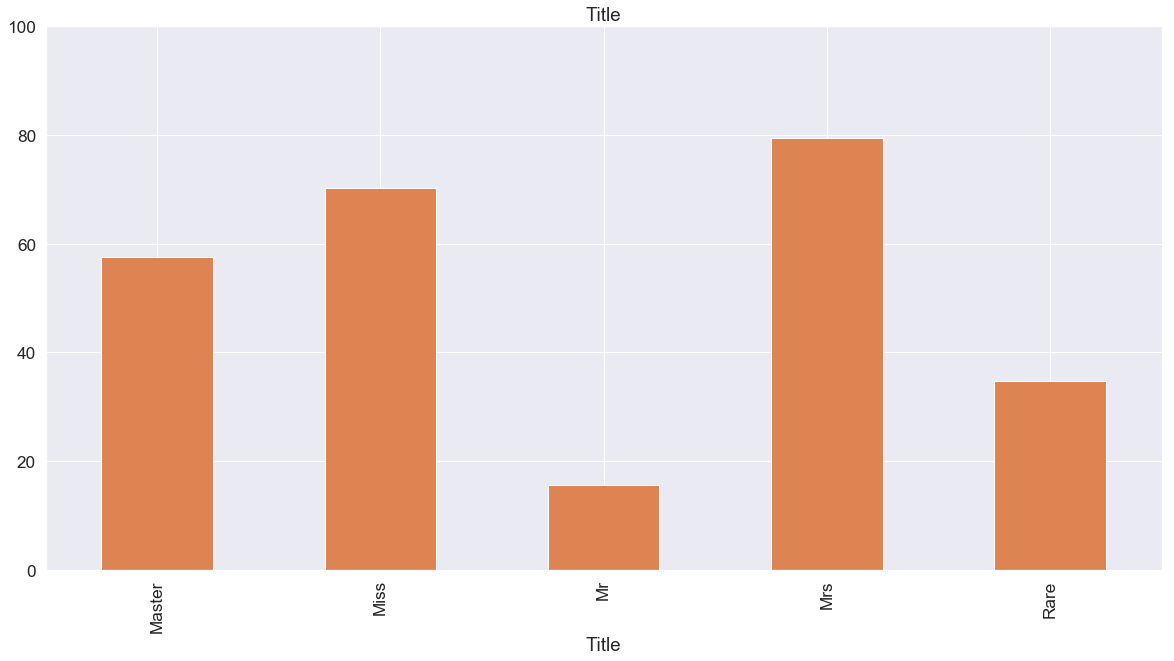

In [16]:
all_data = [train, test]

# replace the elements on 'Title' with 'Mr', 'Miss', 'Mrs', 'Rare'

for dataset in all_data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
train.pivot_table('PassengerId', 'Title', 'Survived', 'count')\
.apply(lambda x: x.div(x.sum()).mul(100), axis=1)[1]\
.plot(kind='bar', stacked=True, title='Title', figsize=(20, 10), color='C1')\
.set_ylim([0,100])

In [17]:
#Turn the string into number
all_data = [train, test]
titles = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}

for dataset in all_data:
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head(n=10)

,Age,Cabin,Died,Embarked,FamilyCount,Fare,FareCut,FareCutTran,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySurvival,Title
0,22.0,NaN,1.0,S,2,7.2500,"(-0.001, 7.854]",0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,0.5,0
1,38.0,C85,0.0,C,2,71.2833,"(39.688, 512.329]",4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,0.5,2
2,26.0,NaN,0.0,S,1,7.9250,"(7.854, 10.5]",1,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,0.5,1
3,35.0,C123,0.0,S,2,53.1000,"(39.688, 512.329]",4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,0.0,2
4,35.0,NaN,1.0,S,1,8.0500,"(7.854, 10.5]",1,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,0.5,0
5,NaN,NaN,1.0,Q,1,8.4583,"(7.854, 10.5]",1,"Moran, Mr. James",0,6,3,1,0,0.0,330877,0.5,0
6,54.0,E46,1.0,S,1,51.8625,"(39.688, 512.329]",4,"McCarthy, Mr. Timothy J",0,7,1,1,0,0.0,17463,0.5,0
7,2.0,NaN,1.0,S,5,21.0750,"(10.5, 21.679]",2,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0.0,349909,0.0,3
8,27.0,NaN,0.0,S,3,11.1333,"(10.5, 21.679]",2,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1.0,347742,1.0,2
9,14.0,NaN,0.0,C,2,30.0708,"(21.679, 39.688]",3,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1.0,237736,0.0,2


In [18]:
data=train.append(test)

**Age**

Text(0.5,1,'Age Distribution within Titles')

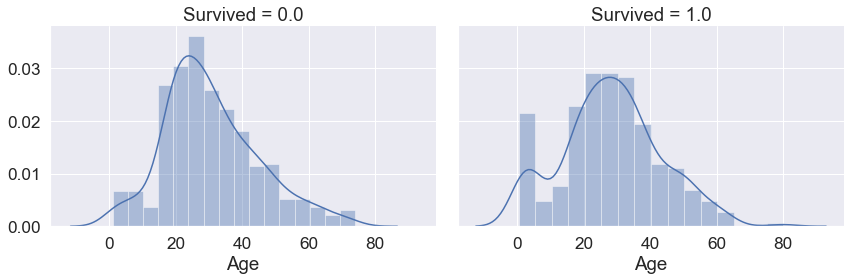

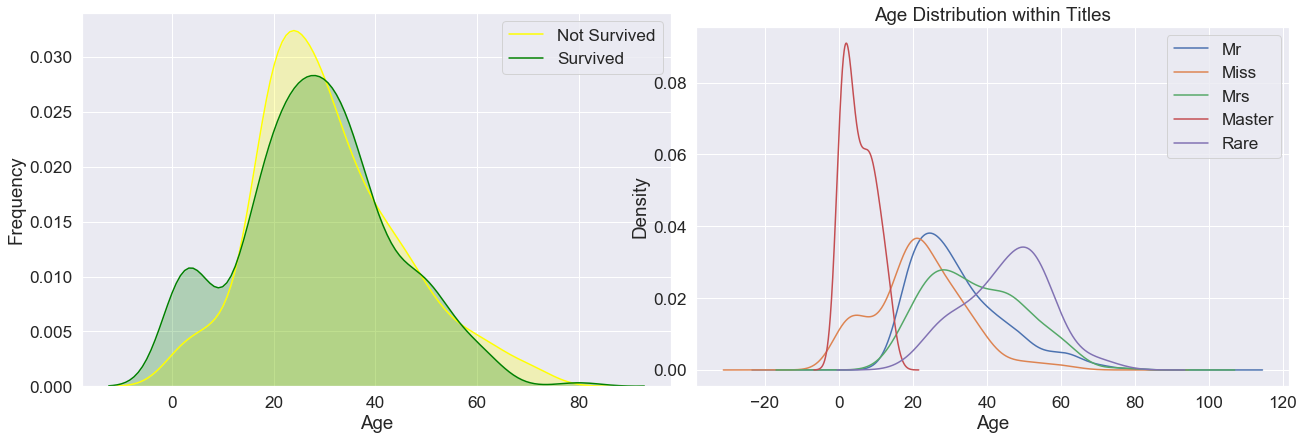

In [19]:
import matplotlib.gridspec as gridspec
g = sns.FacetGrid(data = train, col = 'Survived', height = 4, aspect = 1.5)
g.map(sns.distplot, "Age")
fig = plt.figure(constrained_layout=True,figsize=(18,6))
gs = gridspec.GridSpec(2, 3, figure=fig)
ax = fig.add_subplot(121)
plot = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], ax = ax, color="Yellow", shade = True)
plot = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax = ax, color="Green", shade= True)

plot.set_xlabel("Age")
plot.set_ylabel("Frequency")

plot = plot.legend(["Not Survived","Survived"])
ax2 = fig.add_subplot(122)
data.Age[data.Title == 0].plot(kind='kde')
data.Age[data.Title == 1].plot(kind='kde')    
data.Age[data.Title == 2].plot(kind='kde')
data.Age[data.Title == 3].plot(kind='kde')
data.Age[data.Title == 4].plot(kind='kde')
plt.legend(('Mr', 'Miss','Mrs','Master','Rare'),loc='best') 

plt.xlabel("Age")    
plt.title("Age Distribution within Titles")

In [20]:
#Filling missing age
data=train.append(test)
AgeTitle = data.groupby('Title')['Age'].median().values
data['AgeTitle'] = data['Age']
for i in range(0,5):
    data.loc[(data.Age.isnull()) & (data.Title == i),'AgeTitle'] = AgeTitle[i]
data['AgeTitle'] = data['AgeTitle'].astype('int')
data['AgeDivide'] = ((data['AgeTitle']) < 16.0) * 1

# 4.Training

In [21]:
#Divide it back
train = data[:len(train)]
test = data[len(train):]
train

,Age,Cabin,Died,Embarked,FamilyCount,Fare,FareCut,FareCutTran,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySurvival,Title,AgeTitle,AgeDivide
0,22.0,NaN,1.0,S,2,7.2500,"(-0.001, 7.854]",0,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,0.5,0,22,0
1,38.0,C85,0.0,C,2,71.2833,"(39.688, 512.329]",4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,0.5,2,38,0
2,26.0,NaN,0.0,S,1,7.9250,"(7.854, 10.5]",1,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,0.5,1,26,0
3,35.0,C123,0.0,S,2,53.1000,"(39.688, 512.329]",4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,0.0,2,35,0
4,35.0,NaN,1.0,S,1,8.0500,"(7.854, 10.5]",1,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,0.5,0,35,0
5,NaN,NaN,1.0,Q,1,8.4583,"(7.854, 10.5]",1,"Moran, Mr. James",0,6,3,1,0,0.0,330877,0.5,0,29,0
6,54.0,E46,1.0,S,1,51.8625,"(39.688, 512.329]",4,"McCarthy, Mr. Timothy J",0,7,1,1,0,0.0,17463,0.5,0,54,0
7,2.0,NaN,1.0,S,5,21.0750,"(10.5, 21.679]",2,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0.0,349909,0.0,3,2,1
8,27.0,NaN,0.0,S,3,11.1333,"(10.5, 21.679]",2,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1.0,347742,1.0,2,27,0
9,14.0,NaN,0.0,C,2,30.0708,"(21.679, 39.688]",3,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1.0,237736,0.0,2,14,1


In [22]:
# Inputs set and labels

X_train = train.drop(labels=['Survived','PassengerId'],axis=1)
Y_train = train['Survived']
X_test = test.drop(labels=['PassengerId'],axis=1)

**XgbBoost**

In [23]:
subset = ['Sex','Pclass','FareCutTran','FamilySurvival','AgeDivide']
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.003,n_estimators=1600,
                                max_depth=5, min_child_weight=2,
                                gamma=9, subsample=0.7,
                                colsample_bytree=0.7,
                                objective= 'binary:logistic',
                                scale_pos_weight=1, seed=35,
                                reg_alpha=0.4)
model.fit(X_train[subset], Y_train)
y_pred = model.predict(X_test[subset])
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':y_pred})

**Random Forest**

In [24]:
subset = ['Sex','Pclass','FareCutTran','FamilySurvival','AgeDivide']
Model = RandomForestClassifier(random_state=35,n_estimators=100,min_samples_split=20,oob_score=True)
Model.fit(X_train[subset], Y_train)
print('oob score :%.5f' %(Model.oob_score_))

oob score :0.84512


In [25]:
# submits

pred = Model.predict(X_test[subset])

submit = pd.DataFrame({"PassengerId": test['PassengerId'],
                      "Survived":pred.astype(int)})
submit.to_csv("submission.csv",index=False)

**KNN**

In [26]:
from sklearn.preprocessing import StandardScaler
subset = ['Sex','Pclass','FareCutTran','FamilySurvival','AgeDivide']
std_scaler = StandardScaler()
Xk_train = std_scaler.fit_transform(X_train[subset])
Xk_test = std_scaler.transform(X_test[subset])

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier #KNN
n_neighbors = [10,11,12,13,14,15,16,17,18,19]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(Xk_train, Y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8817237727318931
KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=19, p=2,
           weights='distance')


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   22.9s finished


In [28]:
gd.best_estimator_.fit(Xk_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=19, p=2,
           weights='distance')

In [29]:
# submits

kpred = gd.best_estimator_.predict(Xk_test)

ksubmit = pd.DataFrame({"PassengerId": test['PassengerId'],
                      "Survived":kpred.astype(int)})


# 5. Model Evaluation

In [34]:
models = {'KNN':gd.best_estimator_,
          'RF':Model,
          'XGB':model}

In [35]:
def calculate_cross_validation_scores(models, X_train, Y_train, kfold):
    CrossValScores = pd.DataFrame(columns = ['Algorithm', 'Method', 'CVMean', 'CVSTD'])
    CrossValPredictions = pd.DataFrame()
    
    def calculate_model_cross_validation_scores(model):
        cv_results = cross_val_score(model, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4) 
        cv_mean = cv_results.mean()
        cv_std = cv_results.std()
        cv_predictions = cross_val_predict(model, X_train, y = Y_train, cv = kfold, n_jobs=4)
        return cv_mean, cv_std, cv_predictions
    
    for model_name, model in models.items():
        cv_mean, cv_std, cv_predictions = calculate_model_cross_validation_scores(model)
        CrossValScores = CrossValScores.append({'Algorithm':model_name,'Method':'Single Classifier', 'CVMean':cv_mean,'CVSTD':cv_std}, ignore_index=True)
        CrossValPredictions[model_name] = cv_predictions
    
    return CrossValScores, CrossValPredictions

In [36]:
kfold = StratifiedKFold(n_splits=10)
CrossValScores, CrossValPredictions = calculate_cross_validation_scores(models, X_train[subset], Y_train, kfold)

  Algorithm             Method    CVMean     CVSTD
1        RF  Single Classifier  0.842842  0.033828
0       KNN  Single Classifier  0.839472  0.029013
2       XGB  Single Classifier  0.831618  0.030667


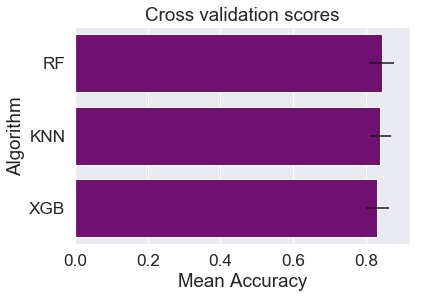

In [37]:
CrossValScores.sort_values('CVMean', ascending=False, inplace=True)
g = sns.barplot('CVMean','Algorithm',data = CrossValScores, color='purple', xerr=CrossValScores['CVSTD']*1)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross validation scores")
print(CrossValScores)

The result show that all three models have a good performance, with random forest slightly better. So we use it as submission.